# Neural Networks with TensorFlow and Keras 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
print(pd.__version__)

0.20.3


In [4]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.3.0


In [5]:
import keras
print(keras.__version__)

Using TensorFlow backend.


2.0.9


## First Step: Load Data and disassemble for our purposes
### We need a few more data point samples for this approach

In [6]:
# df = pd.read_csv('./insurance-customers-300.csv', sep=';')
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')

In [7]:
y=df['group']

In [8]:
X = df.as_matrix()

In [9]:
df.drop('group', axis='columns', inplace=True)

In [10]:
df.describe()

,max speed,age,thousand km per year
count,1500.000000,1500.000000,1500.000000
mean,171.386000,44.969333,30.511333
std,19.269126,16.935040,15.112317
min,118.000000,18.000000,5.000000
25%,158.000000,32.000000,18.000000
50%,170.000000,42.000000,29.000000
75%,187.000000,55.000000,42.000000
max,216.000000,90.000000,84.000000


## Second Step: Deep Learning as Alchemy

In [11]:
# ignore this, it is just technical code
# should come from a lib, consider it to appear magically 
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap_print = ListedColormap(['#AA8888', '#004000', '#FFFFDD'])
cmap_bold = ListedColormap(['#AA4444', '#006000', '#AAAA00'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFDD'])
font_size=25

def meshGrid(x_data, y_data):
    h = 1  # step size in the mesh
    x_min, x_max = x_data.min() - 1, x_data.max() + 1
    y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plotPrediction(clf, x_data, y_data, x_label, y_label, colors, title="", mesh=True, fname=None):
    xx,yy = meshGrid(x_data, y_data)
    plt.figure(figsize=(20,10))

    if clf and mesh:
        grid_X = np.array(np.c_[yy.ravel(), xx.ravel()])
        Z = clf.predict(grid_X)
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    if fname:
        plt.scatter(x_data, y_data, c=colors, cmap=cmap_print, s=200, marker='o', edgecolors='k')
    else:
        plt.scatter(x_data, y_data, c=colors, cmap=cmap_bold, s=80, marker='o', edgecolors='k')
    plt.xlabel(x_label, fontsize=font_size)
    plt.ylabel(y_label, fontsize=font_size)
    plt.title(title, fontsize=font_size)
    if fname:
        plt.savefig(fname)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((900, 4), (900,), (600, 4), (600,))

In [15]:
X_train_kmh_age = X_train[:, :2]
X_test_kmh_age = X_test[:, :2]
X_train_2_dim = X_train_kmh_age
X_test_2_dim = X_test_kmh_age

In [16]:
# tiny little pieces of feature engeneering
from keras.utils.np_utils import to_categorical

num_categories = 3

y_train_categorical = to_categorical(y_train, num_categories)
y_test_categorical = to_categorical(y_test, num_categories)

In [17]:
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model
from keras.layers import Dropout

drop_out = 0.3

inputs = Input(name='input', shape=(2, ))
x = Dense(100, name='hidden1', activation='sigmoid')(inputs)
x = Dropout(drop_out)(x)
x = Dense(100, name='hidden2', activation='sigmoid')(x)
x = Dropout(drop_out)(x)
x = Dense(100, name='hidden3', activation='sigmoid')(x)
x = Dropout(drop_out)(x)
# x = Dense(100, name='hidden4', activation='sigmoid')(x)
# x = Dropout(drop_out)(x)
# x = Dense(100, name='hidden5', activation='sigmoid')(x)
# x = Dropout(drop_out)(x)
predictions = Dense(3, name='softmax', activation='softmax')(x)
model = Model(input=inputs, output=predictions)

# loss function: http://cs231n.github.io/linear-classify/#softmax
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2)                 0         
_________________________________________________________________
hidden1 (Dense)              (None, 100)               300       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
hidden3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
__________

### What is the intuition here: none, just fiddle around like everyone
This might be frustrating or even seem wrong, but trust me: this is what everyone does

In [18]:
%time model.fit(X_train_2_dim, y_train_categorical, epochs=1000, validation_split=0.2, verbose=0, batch_size=100)

CPU times: user 51.7 s, sys: 11.1 s, total: 1min 2s
Wall time: 30.8 s


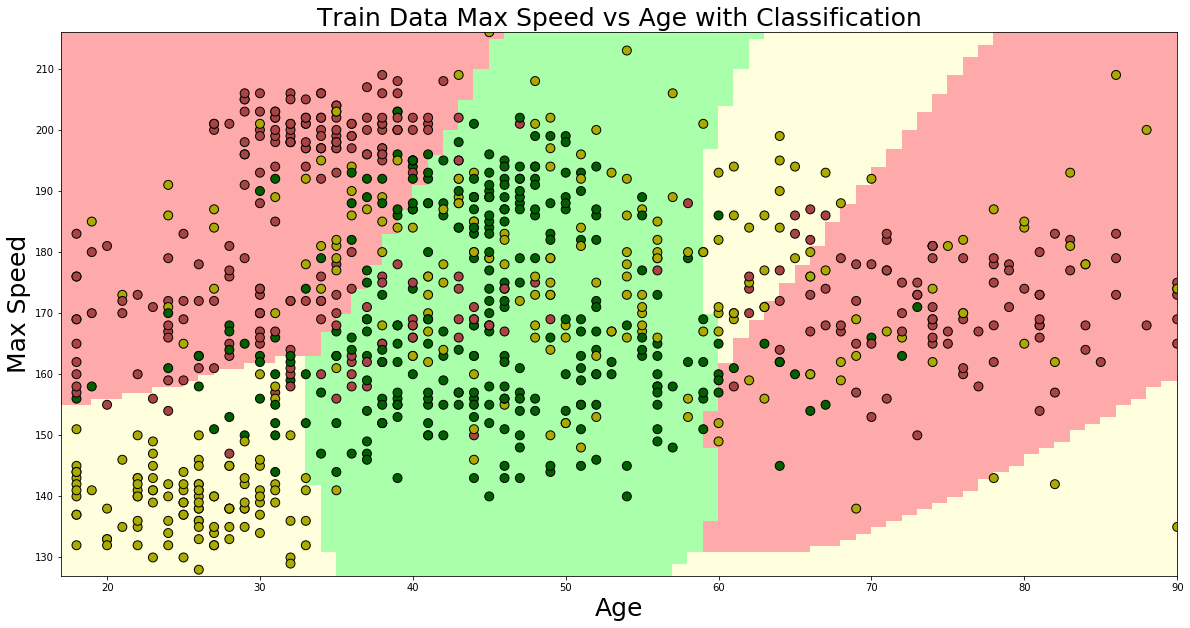

In [20]:
plotPrediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data Max Speed vs Age with Classification")

In [21]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train_categorical, batch_size=100)
train_loss, train_accuracy

900/900 [==============================] - 0s 30us/step


(0.75035525692833793, 0.68222222063276505)

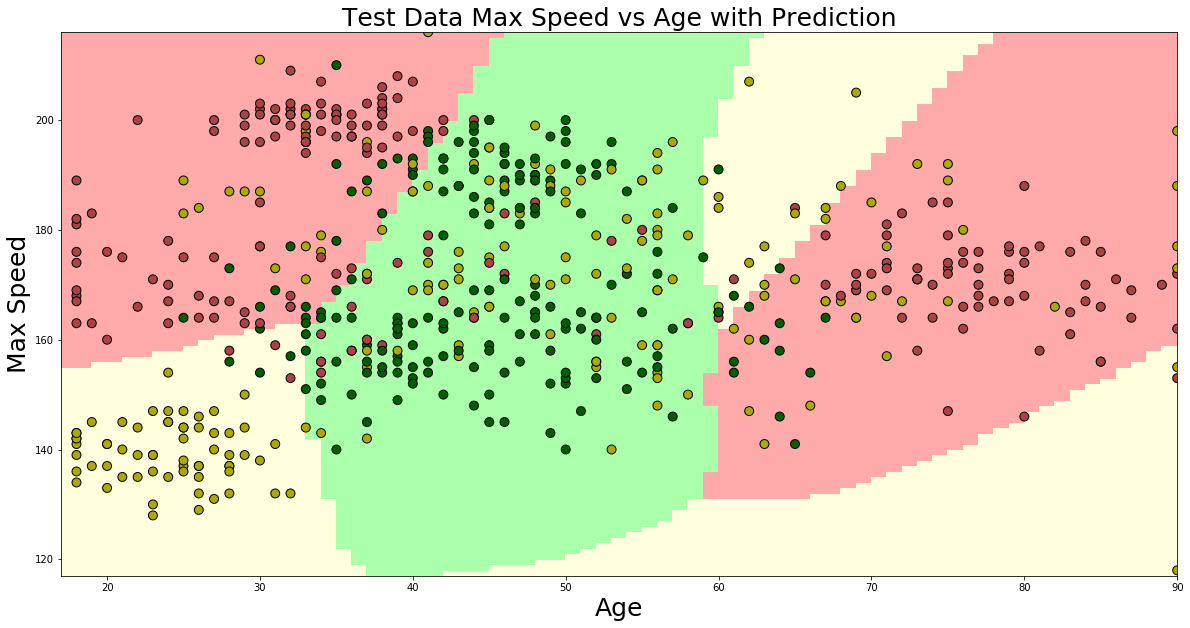

In [22]:
plotPrediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data Max Speed vs Age with Prediction")

In [24]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test_categorical, batch_size=100)
test_loss, test_accuracy

600/600 [==============================] - 0s 31us/step


(0.7401458124319712, 0.66666666666666663)

### No overfitting, probably as good as it gets
## Does this look like your manual solution?
### The machine isn't better than you?

Your brain is a great pattern matcher, but only in 2-d. 

## Third Step: Publish Model to Google Cloud ML and try it out